<a href="https://colab.research.google.com/github/Vhernan123/Notebook-Trabajo-Final-Master/blob/main/eleccion_variable_predictora_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [ ]:
ruta = "/content/drive/MyDrive/mis_archivos_tfm/mi_grilla_original.csv"
df = pd.read_csv(ruta)
df.drop("Unnamed: 0", axis=1, inplace=True)

Correlaciones entre variables con la variable objetivo

# 1. elección de  prom_mujer y edad_media

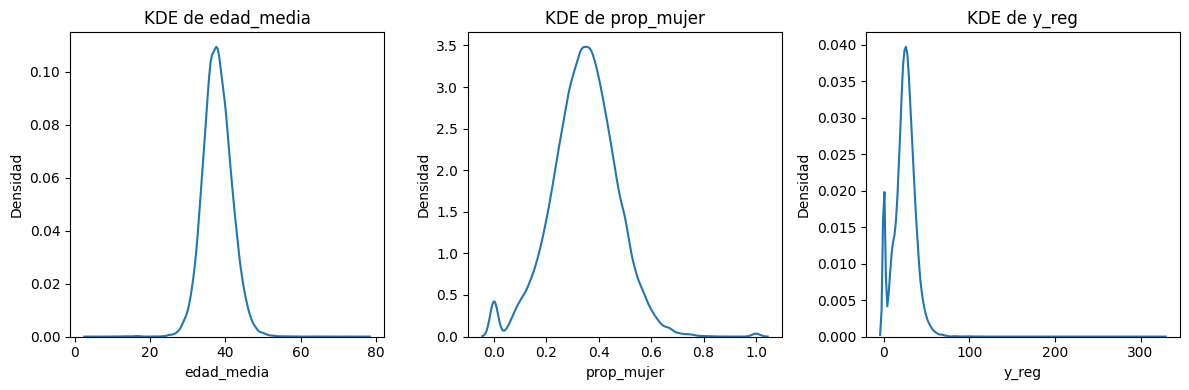

In [ ]:


vars_kde = ["edad_media", "prop_mujer", "y_reg"]

plt.figure(figsize=(12, 4))

for i, col in enumerate(vars_kde, 1):
    plt.subplot(1, 3, i)
    sns.kdeplot(data=df, x=col)
    plt.title(f"KDE de {col}")
    plt.xlabel(col)
    plt.ylabel("Densidad")

plt.tight_layout()
plt.show()


In [ ]:
df['edad_media'].describe()



,edad_media
count,38263.000000
mean,37.908221
std,3.845235
min,4.000000
25%,35.421849
50%,37.782468
75%,40.322691
max,77.000000


In [ ]:
df['prop_mujer'].describe()

,prop_mujer
count,38263.000000
mean,0.344467
std,0.124336
min,0.000000
25%,0.269231
50%,0.346154
75%,0.423077
max,1.000000


edad_media

El KDE muestra una distribución unimodal, concentrada aproximadamente entre los 30 y 50 años, con un pico alrededor de los 40 años. Aunque la variable presenta una forma relativamente compacta, se observa una variabilidad suficiente entre sectores, lo cual indica que la edad promedio no es uniforme en todo el territorio. Esta variabilidad permite que la variable actúe como una covariable de control que captura diferencias demográficas estructurales entre zonas.

Conclusión: la distribución no es degenerada y presenta dispersión significativa → apta como variable predictora.

2. prop_mujer

El KDE evidencia una distribución amplia, extendida desde valores cercanos a 0 hasta aproximadamente 0.7, con mayor concentración entre 0.30 y 0.50. Esta amplitud refleja que la composición por género varía de manera notable entre sectores, lo cual es estadísticamente deseable porque introduce heterogeneidad explicativa útil para el modelo. La presencia de varios modos menores al inicio de la distribución también sugiere que existen grupos de sectores con perfiles demográficos diferenciados.

Conclusión: presenta alta variabilidad, muy útil para capturar diferencias en patrones delictivos → variable relevante.

3. y_reg (delitos del día siguiente)

La variable objetivo muestra una distribución fuertemente asimétrica hacia la derecha (right-skewed), con la mayoría de valores concentrados entre 0 y 50 delitos, pero con una cola larga que llega incluso por encima de los 300 delitos en días excepcionales. Este patrón es característico de variables delictivas sumatorias en grandes ciudades y confirma que el fenómeno tiene alta variabilidad y eventos extremos. Desde una perspectiva estadística, esta forma de distribución respalda el uso de modelos capaces de capturar no linealidades y efectos acumulativos, como Random Forest.

Conclusión: variable con alto rango, dispersión y presencia de valores elevados → apta para modelado predictivo.

# 2.1 KDE comparando fin de semana vs no fin de semana para y_reg

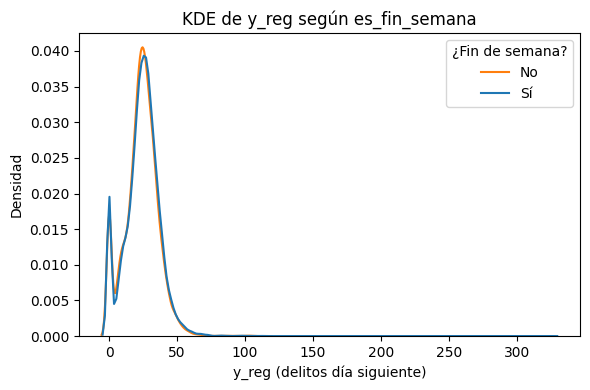

In [ ]:
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df, x="y_reg", hue="es_fin_semana", common_norm=False)
plt.title("KDE de y_reg según es_fin_semana")
plt.xlabel("y_reg (delitos día siguiente)")
plt.ylabel("Densidad")
plt.legend(title="¿Fin de semana?", labels=["No", "Sí"])
plt.tight_layout()
plt.show()


 ## 2.2 boxplot comparando fin de semana vs no fin de semana para y_reg

 ## 2.3 prueba estadistica fin de semana vs no fin de semana para y_reg saber si hay diferencia significativas entre los grupos

In [ ]:
from scipy.stats import mannwhitneyu

week = df[df["es_fin_semana"] == 0]["y_reg"]
weekend = df[df["es_fin_semana"] == 1]["y_reg"]

stat, p = mannwhitneyu(week, weekend, alternative='two-sided')

print("Mann–Whitney U statistic:", stat)
print("p-value:", p)


Mann–Whitney U statistic: 179813911.5
p-value: 3.4422049410346157e-07


# 3. Lags delictivos (delitos_total_lag1, delitos_con_arma_lag1, delitos_total_lag2, delitos_con_arma_lag2, delitos_total_lag3, delitos_con_arma_lag3, delitos_total_lag4, delitos_con_arma_lag4, delitos_total_lag5, delitos_con_arma_lag5, delitos_total_lag6, delitos_con_arma_lag6, delitos_total_lag7, delitos_con_arma_lag7)

l gráfico de autocorrelación muestra que el número de delitos diarios presenta una fuerte dependencia temporal: el valor de un día está muy relacionado con los valores de los días anteriores. En particular, la autocorrelación es elevada para los primeros retrasos (lags), y se mantiene significativa incluso pasados 30 días. Esto indica que el fenómeno delictivo tiene memoria y evoluciona de forma gradual, por lo que resulta estadísticamente justificado incluir en el modelo los lags diarios del delito (delitos_total_lag1 a delitos_total_lag7) como variables predictoras clave.

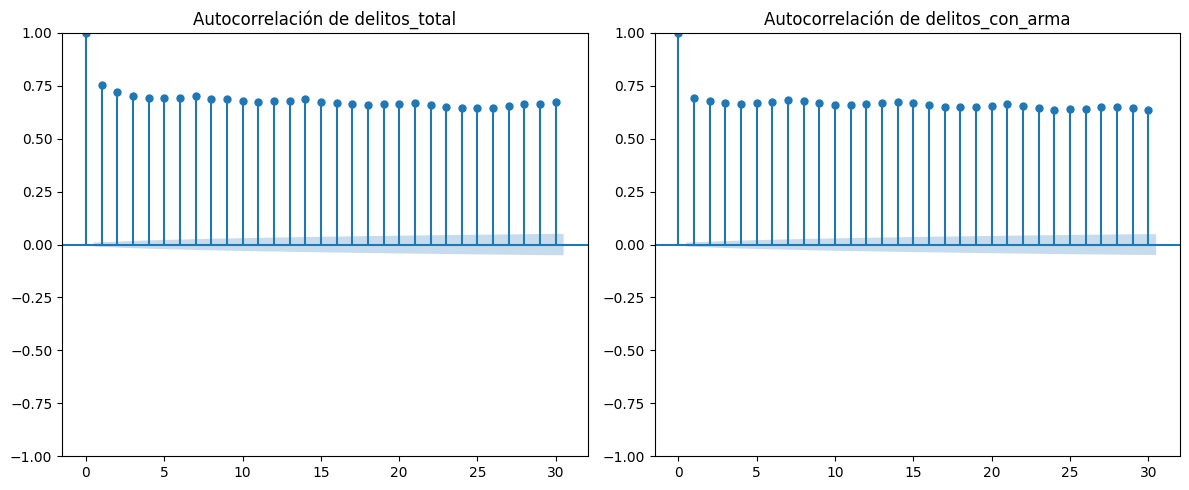

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 5))

# --- Subplot 1: ACF delitos_total
plt.subplot(1, 2, 1)
plot_acf(df['delitos_total'].dropna(), lags=30, ax=plt.gca())
plt.title("Autocorrelación de delitos_total")

# --- Subplot 2: ACF delitos_con_arma
plt.subplot(1, 2, 2)
plot_acf(df['delitos_con_arma'].dropna(), lags=30, ax=plt.gca())
plt.title("Autocorrelación de delitos_con_arma")

plt.tight_layout()
plt.show()



Correlaciones de los lags con la variable predictiva

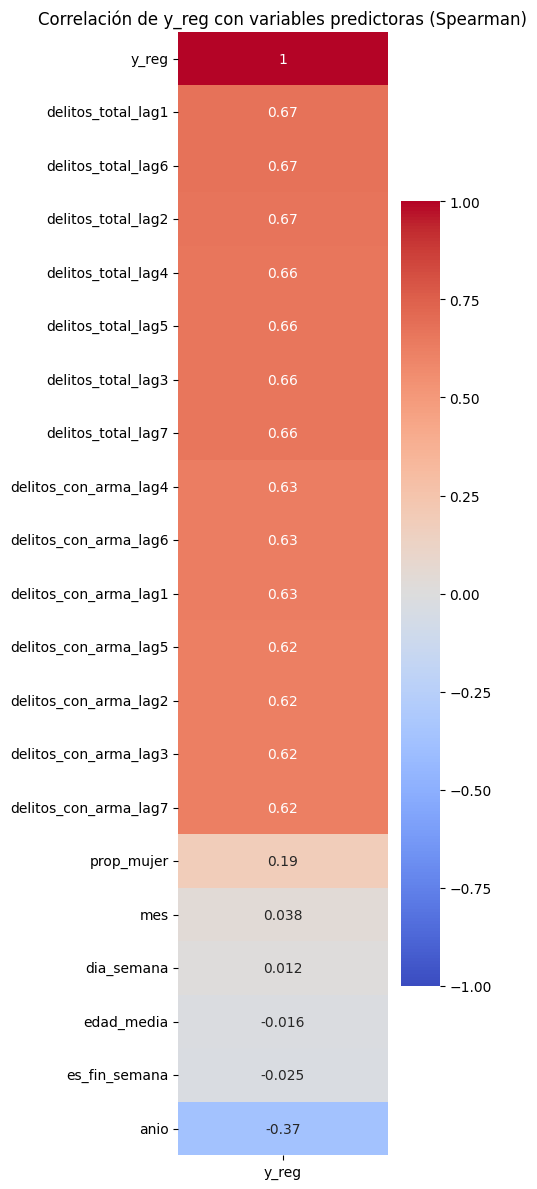

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de tus predictoras
predictoras = [
    "edad_media", "prop_mujer",
    "delitos_total_lag1", "delitos_con_arma_lag1",
    "delitos_total_lag2", "delitos_con_arma_lag2",
    "delitos_total_lag3", "delitos_con_arma_lag3",
    "delitos_total_lag4", "delitos_con_arma_lag4",
    "delitos_total_lag5", "delitos_con_arma_lag5",
    "delitos_total_lag6", "delitos_con_arma_lag6",
    "delitos_total_lag7", "delitos_con_arma_lag7",
    "anio", "mes", "dia_semana", "es_fin_semana"
]

# Matriz de correlación (Spearman)
corr_matrix = df[predictoras + ["y_reg"]].corr(method="spearman")

# Extraer solo la columna de correlación con y_reg
corr_y = corr_matrix[["y_reg"]].sort_values("y_reg", ascending=False)

# Heatmap
plt.figure(figsize=(5,12))
sns.heatmap(corr_y, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlación de y_reg con variables predictoras (Spearman)")
plt.tight_layout()
plt.show()


# 5. Variables anio, semana, dia_semana

Boxplot por día semana

/tmp/ipython-input-860842050.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


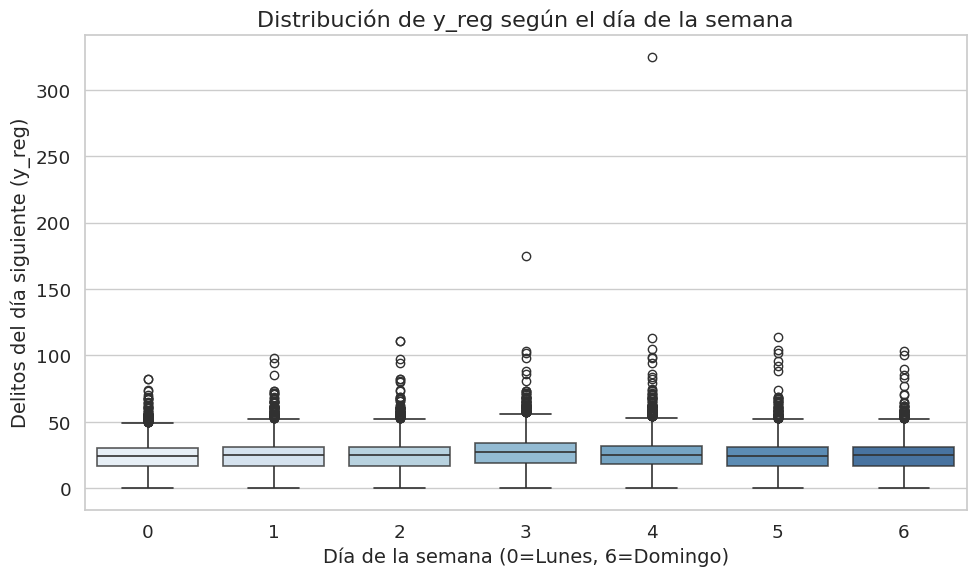

In [ ]:

plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid", font_scale=1.2)

sns.boxplot(
    data=df,
    x="dia_semana",
    y="y_reg",
    palette="Blues",
    showfliers=True,        # puedes poner False si no quieres outliers
    linewidth=1.2,
    boxprops={'alpha':0.8}
)

plt.title("Distribución de y_reg según el día de la semana", fontsize=16)
plt.xlabel("Día de la semana (0=Lunes, 6=Domingo)", fontsize=14)
plt.ylabel("Delitos del día siguiente (y_reg)", fontsize=14)
plt.tight_layout()
plt.show()



# Prueba de hipótesis para evidenciar si existen diferencias significativas entre las distribuciones de reg_y segmentada por los días de la semana (Kruskal–Wallis)

In [ ]:
from scipy.stats import kruskal

# separar por día de la semana
grupos = [df[df["dia_semana"] == d]["y_reg"] for d in sorted(df["dia_semana"].unique())]

stat, p = kruskal(*grupos)

print("Kruskal–Wallis H statistic:", stat)
print("p-value:", p)


Kruskal–Wallis H statistic: 217.08480080944415
p-value: 4.3531652525436764e-44


promedio por mes

/tmp/ipython-input-3876362629.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


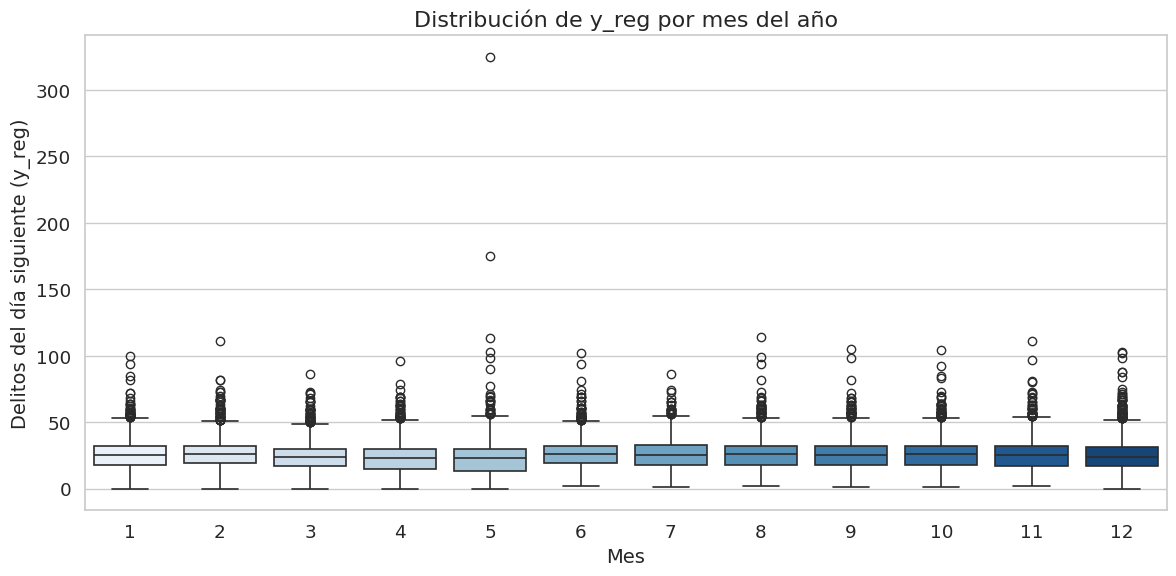

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.set_theme(style="whitegrid", font_scale=1.2)

sns.boxplot(
    data=df,
    x="mes",
    y="y_reg",
    palette="Blues",
    linewidth=1.2,
    showfliers=True  # pon False si quieres ocultar outliers
)

plt.title("Distribución de y_reg por mes del año", fontsize=16)
plt.xlabel("Mes", fontsize=14)
plt.ylabel("Delitos del día siguiente (y_reg)", fontsize=14)

plt.tight_layout()
plt.show()


prueba hipótesis para meses

In [ ]:
from scipy.stats import kruskal

# Crear grupos: lista de 12 series (una por cada mes)
grupos_mes = [df[df["mes"] == m]["y_reg"] for m in sorted(df["mes"].unique())]

# Prueba Kruskal–Wallis
stat, p = kruskal(*grupos_mes)

print("Kruskal–Wallis H statistic:", stat)
print("p-value:", p)


Kruskal–Wallis H statistic: 444.53934817510634
p-value: 2.0914776325917652e-88


# tendencia por años

/tmp/ipython-input-1197797642.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


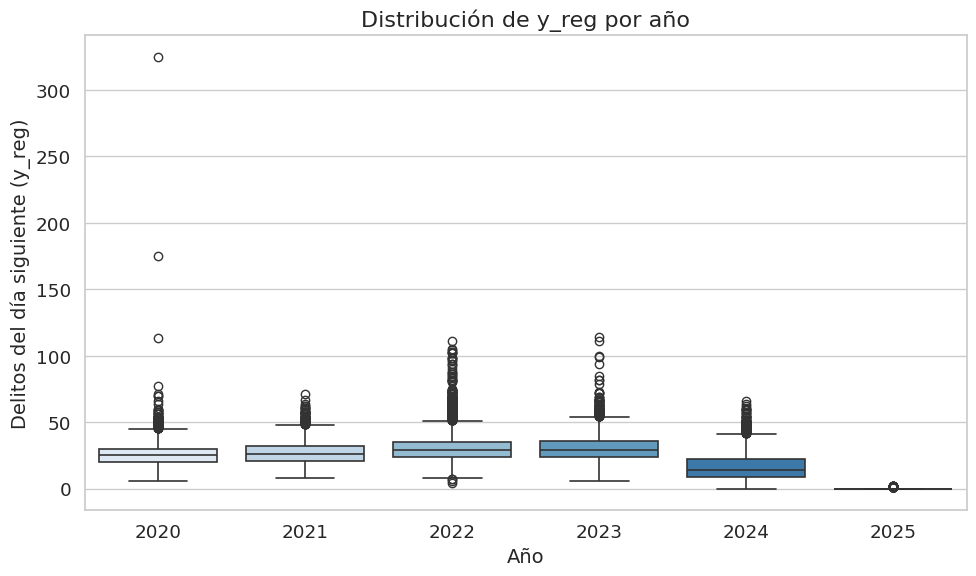

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid", font_scale=1.2)

sns.boxplot(
    data=df,
    x="anio",
    y="y_reg",
    palette="Blues",
    linewidth=1.2,
    showfliers=True  # poner False si quieres ocultar outliers
)

plt.title("Distribución de y_reg por año", fontsize=16)
plt.xlabel("Año", fontsize=14)
plt.ylabel("Delitos del día siguiente (y_reg)", fontsize=14)

plt.tight_layout()
plt.show()
